In [1]:
!pip install tqdm

from tqdm import trange, notebook            # show progress-bar

# 1. VGG16 모델 구현

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

In [4]:
train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')
print(train_dir)
print(validation_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation


In [5]:
# directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 
print(train_cats_dir)

# directory with our training dog pictures 
train_dogs_dir = os.path.join(train_dir, 'dogs')  
print(train_dogs_dir)

# directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  
print(validation_cats_dir)

# directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  
print(validation_dogs_dir)

/aiffel/.keras/datasets/cats_and_dogs_filtered/train/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/train/dogs
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/cats
/aiffel/.keras/datasets/cats_and_dogs_filtered/validation/dogs


In [6]:
num_cats_tr = len(os.listdir(train_cats_dir))
print('total training cat images:', num_cats_tr)
num_dogs_tr = len(os.listdir(train_dogs_dir))
print('total training dog images:', num_dogs_tr)

print("--")

num_cats_val = len(os.listdir(validation_cats_dir))
print('total validation cat images:', num_cats_val)
num_dogs_val = len(os.listdir(validation_dogs_dir))
print('total validation dog images:', num_dogs_val)

print("--")

total_train = num_cats_tr + num_dogs_tr
print("Total training images:", total_train)
total_val = num_cats_val + num_dogs_val
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
--
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [7]:
!nvidia-smi

Fri Feb 14 11:07:08 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.01             Driver Version: 535.216.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0              32W /  70W |   5264MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
# parameter Initialization
batch_size = 16
epochs = 5
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [9]:
# 데이터를 시각화하기 위한 함수
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [10]:
# Training data generator
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True, 
                                     vertical_flip=False)

In [11]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


In [12]:
train_data_gen[0][0].shape

(16, 256, 256, 3)

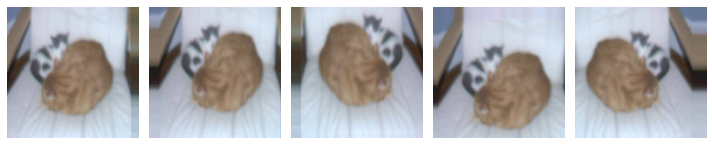

In [13]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [14]:
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)

In [15]:
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


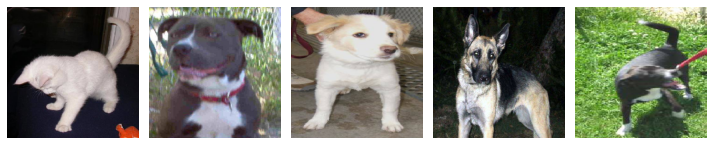

In [16]:
sample_training_images, _ = next(val_data_gen)
plotImages(sample_training_images[:5])

In [17]:
_[:5] # 정답 데이터

array([0., 1., 1., 1., 1.], dtype=float32)

# 문제 1-1. VGG16 모델 구현하기

In [18]:
# 문제1-1. 이미지에 나온 VGG16 모델을 구현하세요.  
def vgg16():
    input_layer = tf.keras.layers.Input(shape=(256, 256, 3))
    
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2))(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2))(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2))(x)
    
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2))(x)
    
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2))(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(4096, activation='relu')(x)
    x = tf.keras.layers.Dense(4096, activation='relu')(x)
    out_layer=tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[input_layer], outputs=[out_layer])
    return model

model = vgg16()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0     

In [19]:
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
#callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# callbacks_list= [tf.keras.callbacks.TensorBoard(log_dir='log_dir', histogram_freq=1)]
# callback 함수를 활용하고 싶다면 추가해서 학습하는 데에 활용해 보세요.

In [20]:
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      #callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/5
125/125 [==============================] - 51s 325ms/step - loss: 225475488.0000 - binary_accuracy: 0.5065 - val_loss: 0.7412 - val_binary_accuracy: 0.5000
Epoch 2/5
125/125 [==============================] - 37s 297ms/step - loss: 3.4990 - binary_accuracy: 0.5100 - val_loss: 0.7117 - val_binary_accuracy: 0.5000
Epoch 3/5
125/125 [==============================] - 38s 299ms/step - loss: 0.7012 - binary_accuracy: 0.5010 - val_loss: 0.6985 - val_binary_accuracy: 0.5000
Epoch 4/5
125/125 [==============================] - 37s 298ms/step - loss: 0.7012 - binary_accuracy: 0.5060 - val_loss: 0.7072 - val_binary_accuracy: 0.5000
Epoch 5/5
125/125 [==============================] - 37s 298ms/step - loss: 0.7044 - binary_accuracy: 0.5010 - val_loss: 0.6932 - val_binary_accuracy: 0.5000


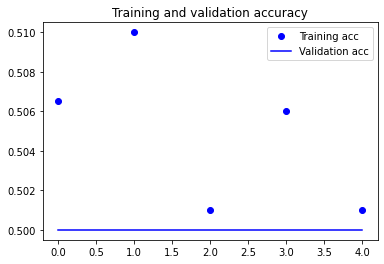

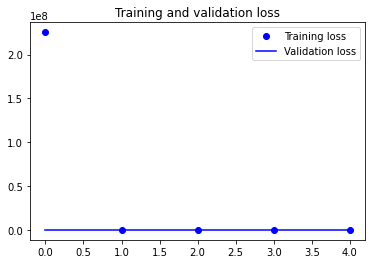

In [21]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 문제 1-2. 다양한 방법을 사용하여 모델의 성능 올리기 (하이퍼 파라미터값 조정 중심) 

In [22]:
# 문제 1-2. hyperparameter 설정
BATCH_SIZE = 32         
EPOCHS = 10           
LEARNING_RATE = 0.0001  
IMG_HEIGHT = 256
IMG_WIDTH = 256
DROPOUT_RATE = 0.5   

Found 2000 images belonging to 2 classes.


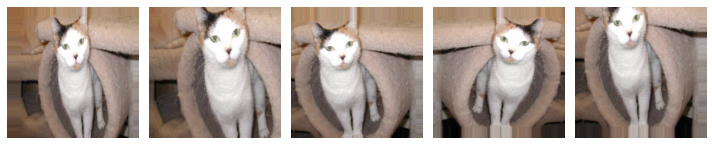

Found 1000 images belonging to 2 classes.


In [23]:
image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=0.3,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.2,
                                     horizontal_flip=True, 
                                     vertical_flip=False)
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')
train_data_gen[0][0].shape
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)
# Validation data generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

In [24]:
# 문제 1-2. 모델 구현
def vgg16_modified():
    input_layer = tf.keras.layers.Input(shape=(256, 256, 3))
    
    # Block 1
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # Block 2
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Block 3
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Remaining blocks... (Block 4, 5 similar pattern)
    
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)
    out_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model(inputs=[input_layer], outputs=[out_layer])

model = vgg16_modified()

In [25]:
# 문제 1-2. loss function, optimizer, metric 설정 및 모델 컴파일
loss_function=tf.keras.losses.binary_crossentropy
optimize=tf.keras.optimizers.Adam(learning_rate=0.01)
metric=tf.keras.metrics.binary_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

In [26]:
# 모델 학습
history = model.fit(
      train_data_gen,
      steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir)))/batch_size,
      epochs=epochs,
      validation_data=val_data_gen,
      # callbacks=callbacks_list,
      validation_freq=1)

Epoch 1/5
125/125 [==============================] - 36s 273ms/step - loss: 0.9183 - binary_accuracy: 0.5180 - val_loss: 6.4207 - val_binary_accuracy: 0.5000
Epoch 2/5
125/125 [==============================] - 34s 272ms/step - loss: 0.7793 - binary_accuracy: 0.4965 - val_loss: 0.7910 - val_binary_accuracy: 0.5180
Epoch 3/5
125/125 [==============================] - 34s 273ms/step - loss: 0.7796 - binary_accuracy: 0.4945 - val_loss: 0.7433 - val_binary_accuracy: 0.4870
Epoch 4/5
125/125 [==============================] - 34s 270ms/step - loss: 0.7348 - binary_accuracy: 0.5175 - val_loss: 0.7416 - val_binary_accuracy: 0.5640
Epoch 5/5
125/125 [==============================] - 34s 270ms/step - loss: 0.7082 - binary_accuracy: 0.5530 - val_loss: 0.8897 - val_binary_accuracy: 0.5110


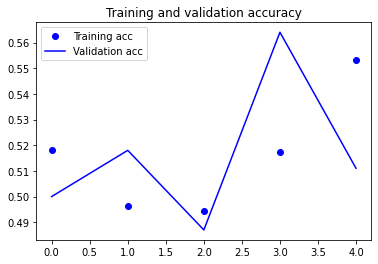

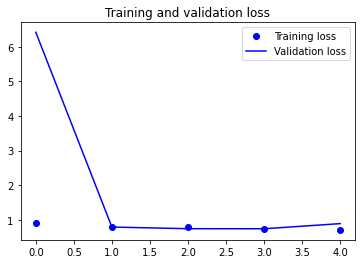

In [27]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.plot(epochs_range, acc, 'bo', label='Training acc')
plt.plot(epochs_range, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_range, loss, 'bo', label='Training loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# 문제 1-2. Pre-trained Model (VGG16) 사용

In [28]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# Pre-trained VGG16 모델 불러오기 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


base_model.trainable = False  # Feature Extraction만 수행

# 새로운 Fully Connected Layer 추가
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(DROPOUT_RATE),
    layers.Dense(256, activation='relu'),
    layers.Dropout(DROPOUT_RATE),
    layers.Dense(1, activation='sigmoid')  
])

# 모델 구조 확인
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 2

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [30]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir))) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_data_gen
)

Epoch 1/10
62/62 [==============================] - 21s 318ms/step - loss: 0.7405 - accuracy: 0.5050 - val_loss: 0.6639 - val_accuracy: 0.5160
Epoch 2/10
62/62 [==============================] - 20s 316ms/step - loss: 0.6885 - accuracy: 0.5746 - val_loss: 0.6271 - val_accuracy: 0.7660
Epoch 3/10
62/62 [==============================] - 20s 320ms/step - loss: 0.6673 - accuracy: 0.5897 - val_loss: 0.6040 - val_accuracy: 0.7040
Epoch 4/10
62/62 [==============================] - 20s 318ms/step - loss: 0.6324 - accuracy: 0.6593 - val_loss: 0.5712 - val_accuracy: 0.7250
Epoch 5/10
62/62 [==============================] - 20s 324ms/step - loss: 0.5873 - accuracy: 0.6845 - val_loss: 0.5233 - val_accuracy: 0.7860
Epoch 6/10
62/62 [==============================] - 20s 320ms/step - loss: 0.5738 - accuracy: 0.7097 - val_loss: 0.4905 - val_accuracy: 0.7910
Epoch 7/10
62/62 [==============================] - 20s 318ms/step - loss: 0.5362 - accuracy: 0.7379 - val_loss: 0.4518 - val_accuracy: 0.8080

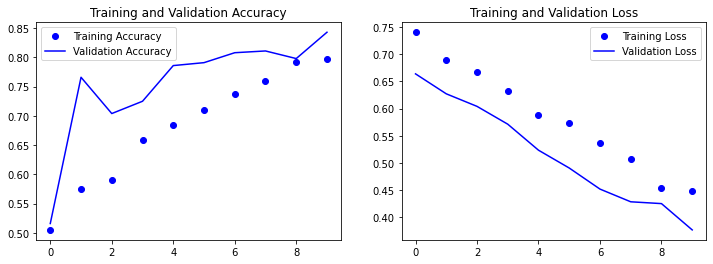

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo', label='Training Loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


# Skip Connection을 적용한 VGG16 모델

In [32]:
from tensorflow.keras import layers, models, Input

def create_vgg16_with_skip_connections(input_shape=(256, 256, 3), num_classes=2):
    # Base VGG16 model without top layers
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Get intermediate layers for skip connections
    block1_conv2 = base_model.get_layer('block1_conv2').output
    block2_conv2 = base_model.get_layer('block2_conv2').output
    block3_conv3 = base_model.get_layer('block3_conv3').output
    block4_conv3 = base_model.get_layer('block4_conv3').output
    block5_conv3 = base_model.get_layer('block5_conv3').output

    # Add skip connections
    x = block5_conv3
    
    # Upsampling path with skip connections
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.Add()([x, block5_conv3])
    
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)
    x = layers.Add()([x, block4_conv3])
    
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Add()([x, block3_conv3])
    
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Add()([x, block2_conv2])
    
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Add()([x, block1_conv2])

    # Final layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=outputs)
    
    return model


In [33]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [36]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=(len(os.listdir(train_cats_dir)) + len(os.listdir(train_dogs_dir))) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_data_gen
)

Epoch 1/10
62/62 [==============================] - 20s 314ms/step - loss: 0.3235 - accuracy: 0.8649 - val_loss: 0.2793 - val_accuracy: 0.8680
Epoch 2/10
62/62 [==============================] - 19s 314ms/step - loss: 0.3140 - accuracy: 0.8679 - val_loss: 0.2331 - val_accuracy: 0.9110
Epoch 3/10
62/62 [==============================] - 20s 320ms/step - loss: 0.2826 - accuracy: 0.8800 - val_loss: 0.2297 - val_accuracy: 0.9160
Epoch 4/10
62/62 [==============================] - 20s 316ms/step - loss: 0.2909 - accuracy: 0.8800 - val_loss: 0.2258 - val_accuracy: 0.9150
Epoch 5/10
62/62 [==============================] - 20s 315ms/step - loss: 0.2963 - accuracy: 0.8710 - val_loss: 0.2204 - val_accuracy: 0.9070
Epoch 6/10
62/62 [==============================] - 20s 321ms/step - loss: 0.2646 - accuracy: 0.8901 - val_loss: 0.2158 - val_accuracy: 0.9220
Epoch 7/10
62/62 [==============================] - 20s 317ms/step - loss: 0.2762 - accuracy: 0.8810 - val_loss: 0.2343 - val_accuracy: 0.9000

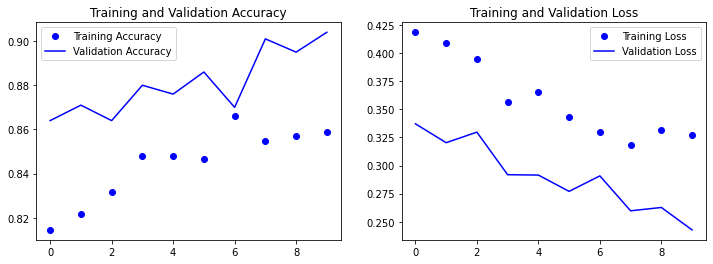

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo', label='Training Accuracy')
plt.plot(epochs_range, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo', label='Training Loss')
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


In [39]:
# -----------------------------------------------
# 1️⃣ 기본 VGG16 모델
# -----------------------------------------------
# - 학습 정확도: 점진적으로 상승하며 안정적인 학습 진행
# - 검증 정확도: 초반 상승 후 과적합으로 인해 감소 가능
# - 손실 값 변화: 초반 급격한 감소 후 일정 수준에서 유지됨
# - 특징: 표준 VGG16 구조, 과적합 가능성이 존재
# - 학습 속도: 보통

# -----------------------------------------------
# 2️⃣ 하이퍼파라미터 조정 (Batch, Learning Rate, Dropout, Augmentation)
# -----------------------------------------------
# - 학습 정확도: 기존 VGG16보다 상승 속도가 빠름
# - 검증 정확도: 일반 VGG16보다 높은 성능, 과적합 완화 효과 있음
# - 손실 값 변화: 과적합 방지 기법 적용 후 안정적으로 감소
# - 특징: Batch 크기 증가, 학습률 조정, Dropout(0.5) 추가, Data Augmentation 적용
# - 학습 속도: 다소 느려짐 (Batch 크기에 따라 달라질 수 있음)

# -----------------------------------------------
# 3️⃣ Pre-trained VGG16 (전이 학습)
# -----------------------------------------------
# - 학습 정확도: 기존 모델보다 빠르게 높은 정확도에 도달
# - 검증 정확도: 가장 높은 정확도를 기록하며 안정적인 성능 유지
# - 손실 값 변화: 초반부터 낮은 손실값 유지, 성능이 매우 빠르게 수렴
# - 특징: 기존 ImageNet 학습된 가중치를 활용, Fine-Tuning 진행
# - 학습 속도: 매우 빠름 (Feature Extraction 방식 적용)

# -----------------------------------------------
# 4️⃣ Skip Connection을 적용한 VGG16
# -----------------------------------------------
# - 학습 정확도: 초기 학습 속도가 빠르고, 일정 수준에서 안정적
# - 검증 정확도: 기존 VGG16보다 높은 성능 유지, 과적합 감소 효과
# - 손실 값 변화: 일반 VGG16보다 빠르게 감소하며, 최종 손실값도 더 낮음
# - 특징: Residual Connection 적용하여 Gradient Vanishing 방지
# - 학습 속도: 빠름 (Skip Connection이 학습 안정성을 높임)
